## Implementation of RFUAV-net
efficient CNN method - 1D convolution

In [1]:
import os
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from helper_functions import *
from loading_functions import *

import time

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch
import torchvision.models as models
# from torchmetrics import F1Score

In [18]:
# reload functions & modules
import importlib
import nn_functions
importlib.reload(nn_functions)
# from loading_functions import *

<module 'nn_functions' from '/home/kzhou/main/RFClassification/nn_functions.py'>

In [3]:
## Import data -  Drone RF
main_folder = '/home/kzhou/Data/DroneRF/'
t_seg = 0.25 #ms
Xs_arr, ys_arr, y4s_arr, y10s_arr = load_dronerf_raw(main_folder, t_seg)

diff 5 file name: 00000L_13.csv


In [5]:
## check for nans in the data
# tfall = np.isnan(y10s_arr)
# tfall.any()

## Load Data

In [6]:
dataset = DroneData(Xs_arr, y10s_arr)

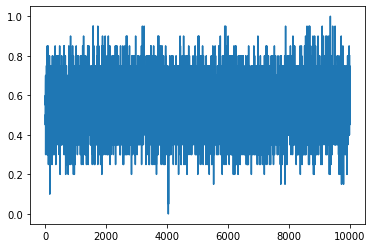

In [7]:
plt.plot(dataset.__getitem__(40)[0][1].numpy())

## Model

In [8]:
class RFUAVNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(RFUAVNet, self).__init__()
        self.num_classes = num_classes

        self.dense = nn.Linear(320, num_classes)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.smax = nn.Softmax(dim=1)
        
        # for r unit
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=5, stride=5)
        self.norm1 = nn.BatchNorm1d(num_features=64)
        self.elu1 = nn.ELU(alpha=1.0, inplace=False)
        
        # setup for components of the gunit
        self.groupconvlist = []
        self.norm2list = []
        self.elu2list = []
        for i in range(4):
            self.groupconvlist.append( nn.Conv1d( 
                  in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  stride = 2,
                  groups=8,
    #               bias=False,
                  dtype=torch.float32
                ))
            self.norm2list.append(nn.BatchNorm1d(num_features=64))
            self.elu2list.append(nn.ELU(alpha=1.0, inplace=False))
        self.groupconv = nn.ModuleList(self.groupconvlist)
        self.norm2 = nn.ModuleList(self.norm2list)
        self.elu2 = nn.ModuleList(self.elu2list)
        
        # multi-gap implementation
        self.avgpool1000 = nn.AvgPool1d(kernel_size=1000)
        self.avgpool500 = nn.AvgPool1d(kernel_size=500)
        self.avgpool250 = nn.AvgPool1d(kernel_size=250)
        self.avgpool125 = nn.AvgPool1d(kernel_size=125)
    
    # Progresses data across layers    
    def forward(self, x):
        # runit first
        x1 = self.runit(x)
        xg1 = self.gunit(F.pad(x1, (1,0)), 0) 
        x2 = self.pool(x1)
        x3 = xg1+x2
        
        # series of gunits
        xg2 = self.gunit(F.pad(x3, (1,0)), 1)
        x4 = self.pool(x3)
        x5 = xg2+x4
        
        xg3 = self.gunit(F.pad(x5, (1,0)), 2)
        x6 = self.pool(x5)
        x7 = x6+xg3
        
        xg4 = self.gunit(F.pad(x7, (1,0)), 3)
        x8 = self.pool(x7)
        x_togap = x8+xg4
        
        
        # gap and multi-gap
        f_gap_1 = self.avgpool1000(xg1)
        f_gap_2 = self.avgpool500(xg2)
        f_gap_3 = self.avgpool250(xg3)
        f_gap_4 = self.avgpool125(xg4)
        
        f_multigap = torch.cat((f_gap_1,f_gap_2, f_gap_3, f_gap_4), 1)
        
        f_gap_add = self.avgpool125(x_togap)
    
        f_final = torch.cat((f_multigap, f_gap_add),1)
        f_flat = f_final.flatten(start_dim=1)
    
        out = self.dense(f_flat)
#         out = self.smax(f_fc)
        # fc_layer
        
        return out
    
    def runit(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.elu1(x)
        return x
        
    def gunit(self, x, n):
        # group convolution layer 8 by 8
        # norm
        # elu
        # n indicates which gunit
        x = self.groupconv[n](x) 
        x = self.norm2[n](x)
        x = self.elu2[n](x)
        return x

In [9]:
## Test network
input1 = dataset.__getitem__(40)[0]
# input1= input1.type(torch.float)
print(input1.shape)
input1 = torch.unsqueeze(input1, 0)
# input = input.reshape(1, 2, 10000)
# input1 = torch.rand(128, 2, 10000)

print(input1.shape)

# input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float)

net = RFUAVNet(3)
out = net(input1)

# print(out.shape)
# print(out)

torch.Size([2, 10000])
torch.Size([1, 2, 10000])


## Training & Testing

In [19]:
from nn_functions import runkfoldcv

In [20]:
# Network Hyperparameters
num_classes = 10
batch_size = 128 # 128
learning_rate = 0.01
num_epochs = 5 # 0
momentum = 0.95
l2reg = 1e-4

In [21]:
## Set up Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RFUAVNet(num_classes)
model = model.to(device)

In [ ]:
k_folds = 10
avg_acc, mean_f1s, mean_runtime = runkfoldcv(
    model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
    Loss after mini-batch    50: 2.41542
    Loss after mini-batch   100: 2.26214
    Loss after mini-batch   150: 2.24467
    Loss after mini-batch   200: 2.22493
    Loss after mini-batch   250: 2.21494
    Loss after mini-batch   300: 2.19337
    Loss after mini-batch   350: 2.18426
    Loss after mini-batch   400: 2.16575
    Loss after mini-batch   450: 2.15854
    Loss after mini-batch   500: 2.12686
    Loss after mini-batch   550: 2.09452
    Loss after mini-batch   600: 2.05638
    Loss after mini-batch   650: 2.03202
    Loss after mini-batch   700: 1.99310
    Loss after mini-batch   750: 1.93961
    Loss after mini-batch   800: 1.90332
    Loss after mini-batch   850: 1.84967
    Loss after mini-batch   900: 1.80608
    Loss after mini-batch   950: 1.74293
    Loss after mini-batch  1000: 1.71577
    Loss after mini-batch  1050: 1.64929
    Loss after mini-batch  1100: 1.63925
    Loss

    Loss after mini-batch   300: 0.48072
    Loss after mini-batch   350: 0.47524
    Loss after mini-batch   400: 0.47279
    Loss after mini-batch   450: 0.47948
    Loss after mini-batch   500: 0.48792
    Loss after mini-batch   550: 0.48250
    Loss after mini-batch   600: 0.48013
    Loss after mini-batch   650: 0.48316
    Loss after mini-batch   700: 0.47780
    Loss after mini-batch   750: 0.46713
    Loss after mini-batch   800: 0.46507
    Loss after mini-batch   850: 0.47164
    Loss after mini-batch   900: 0.47332
    Loss after mini-batch   950: 0.46618
    Loss after mini-batch  1000: 0.49606
    Loss after mini-batch  1050: 0.48513
    Loss after mini-batch  1100: 0.46669
    Loss after mini-batch  1150: 0.46167
    Loss after mini-batch  1200: 0.47981
    Loss after mini-batch  1250: 0.46548
    Loss after mini-batch  1300: 0.48277
    Loss after mini-batch  1350: 0.46534
    Loss after mini-batch  1400: 0.45932
    Loss after mini-batch  1450: 0.47043
    Loss after m

    Loss after mini-batch   650: 0.41997
    Loss after mini-batch   700: 0.41026
    Loss after mini-batch   750: 0.40953
    Loss after mini-batch   800: 0.41708
    Loss after mini-batch   850: 0.41959
    Loss after mini-batch   900: 0.42385
    Loss after mini-batch   950: 0.40577
    Loss after mini-batch  1000: 0.41098
    Loss after mini-batch  1050: 0.39186
    Loss after mini-batch  1100: 0.42776
    Loss after mini-batch  1150: 0.38998
    Loss after mini-batch  1200: 0.40439
    Loss after mini-batch  1250: 0.41166
    Loss after mini-batch  1300: 0.41522
    Loss after mini-batch  1350: 0.41273
    Loss after mini-batch  1400: 0.40155
    Loss after mini-batch  1450: 0.39587
    Loss after mini-batch  1500: 0.39228
    Loss after mini-batch  1550: 0.41351
Starting epoch 4
    Loss after mini-batch    50: 0.40122
    Loss after mini-batch   100: 0.40926
    Loss after mini-batch   150: 0.39708
    Loss after mini-batch   200: 0.39881
    Loss after mini-batch   250: 0.40043

### Single fold train & test development code

In [34]:
# Set up data and parameters

## Set up Data
train_split_percentage = 0.9
split_lengths = [int(train_split_percentage*len(dataset)), len(dataset)-int(train_split_percentage*len(dataset))]
train_set, test_set = torch.utils.data.random_split(dataset, split_lengths)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                           batch_size = batch_size,
                                           shuffle = True)


## Set up Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RFUAVNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2reg, momentum = momentum)  

total_step = len(train_loader)

In [35]:
# Training
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (inputs, labels) in enumerate(train_loader): 
#         inputs = inputs.float()
#         inputs = torch.squeeze(inputs, 1)
        labels = labels.type(torch.long)

        # Move tensors to the configured device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 49:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/10], Loss: 1.1236
Epoch [1/10], Loss: 0.1796
Epoch [1/10], Loss: 0.0654
Epoch [1/10], Loss: 0.0444
Epoch [1/10], Loss: 0.0946
Epoch [1/10], Loss: 0.3310
Epoch [1/10], Loss: 0.0338
Epoch [1/10], Loss: 0.0116
Epoch [1/10], Loss: 0.0436
Epoch [1/10], Loss: 0.0239
Epoch [1/10], Loss: 0.0447
Epoch [1/10], Loss: 0.0318
Epoch [1/10], Loss: 0.0118
Epoch [1/10], Loss: 0.1016
Epoch [1/10], Loss: 0.0420
Epoch [1/10], Loss: 0.0146
Epoch [1/10], Loss: 0.0967
Epoch [1/10], Loss: 0.0204
Epoch [1/10], Loss: 0.0265
Epoch [1/10], Loss: 0.4306
Epoch [1/10], Loss: 0.0651
Epoch [1/10], Loss: 0.0200
Epoch [1/10], Loss: 0.0039
Epoch [1/10], Loss: 0.0336
Epoch [1/10], Loss: 0.0218
Epoch [1/10], Loss: 0.0070
Epoch [1/10], Loss: 0.0286
Epoch [1/10], Loss: 0.0055
Epoch [1/10], Loss: 0.0100
Epoch [1/10], Loss: 0.0097
Epoch [1/10], Loss: 0.0161
Epoch [2/10], Loss: 0.0023
Epoch [2/10], Loss: 0.0172
Epoch [2/10], Loss: 0.0794
Epoch [2/10], Loss: 0.0063
Epoch [2/10], Loss: 0.0133
Epoch [2/10], Loss: 0.0049
E

Epoch [10/10], Loss: 0.0039
Epoch [10/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0044
Epoch [10/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0040


In [37]:
## Check accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = torch.squeeze(inputs, 1)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))


Accuracy of the network on the 22600 train images: 99.86725663716814 %


In [ ]:
# # KFoldCV original implementation
# k_folds = 10

# num_classes =10

# if num_classes == 2:
#     f1type = 'binary'
# else:
#     f1type = 'weighted' # is this the best choice


# # For fold results
# results = {}
# runtimes = np.zeros(k_folds)
# f1s = np.zeros(k_folds)

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=k_folds, shuffle=True)

# # Start print
# print('--------------------------------')

# # K-fold Cross Validation model evaluation
# for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
#     # Print
#     print(f'FOLD {fold}')
#     print('--------------------------------')

#     # Sample elements randomly from a given list of ids, no replacement.
#     train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#     test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

#     # Define data loaders for training and testing data in this fold
#     trainloader = torch.utils.data.DataLoader(
#                       dataset, 
#                       batch_size=batch_size, sampler=train_subsampler)
#     testloader = torch.utils.data.DataLoader(
#                       dataset,
#                       batch_size=batch_size, sampler=test_subsampler)

#     # Init the neural network
#     network = RFUAVNet(num_classes)
#     network = network.to(device)
# #     network.apply(reset_weights)

#     criterion = nn.CrossEntropyLoss()

#     # Initialize optimizer
# #     optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=l2reg, momentum = momentum)  

#     # Run the training loop for defined number of epochs
#     for epoch in range(0, num_epochs):
#         # Print epoch
#         print(f'Starting epoch {epoch+1}')

#         # Set current loss value
#         current_loss = 0.0

#         # Iterate over the DataLoader for training data
#         for i, data in enumerate(trainloader):
#             # Get inputs
#             inputs, targets = data
#             targets= targets.type(torch.long)
                        
#             # Move tensors to configured device
#             inputs = inputs.to(device)
#             targets = targets.to(device)
            
#             # Perform forward pass
#             outputs = network(inputs)
            
#             # Compute loss            
#             loss = criterion(outputs, targets)

#             # Zero the gradients
#             optimizer.zero_grad()

#             # Perform backward pass
#             loss.backward()

#             # Perform optimization
#             optimizer.step()

#             # Print statistics
#             current_loss += loss.item()
#             if i % 50 == 49:
#                 print('    Loss after mini-batch %5d: %.5f' %
#                       (i + 1, current_loss / 50))
#                 current_loss = 0.0
# #         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

#     # Process is complete.
# #     print('Training process has finished. Saving trained model.')

#     # Print about testing
#     print('Starting testing')
#     print('----------------')

#     # Saving the model
# #     save_path = f'./model-fold-{fold}.pth'
# #     torch.save(network.state_dict(), save_path)

#     # Evaluation for this fold
#     correct, total = 0, 0
#     network.eval()
#     with torch.no_grad():
#         starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
#         runtimes_thisfold = []
#         f1s_thisfold = []
#         # Iterate over the test data and generate predictions
#         for i, data in enumerate(testloader, 0):
#             # Get inputs
#             inputs, targets = data
#             inputs = inputs.to(device)
#             targets = targets.to(device)

#             # Generate outputs
#             n_instances = len(inputs)
#             ys = torch.empty(n_instances)
#             ys = ys.to(device)

#             for i in range(n_instances):
#                 instance = inputs[i]
#                 instance = instance.float()
#                 start = time.time()
#                 starter.record()
#                 yi = network(instance)
#                 _,pred = torch.max(yi,1)
#                 ender.record()
                
#                 torch.cuda.synchronize()
#                 curr_time = starter.elapsed_time(ender) #miliseconds

#                 runtimes_thisfold.append(curr_time*1e-3)
#                 ys[i] = pred


#             # Set total and correct
#             total += targets.size(0)
#             correct += (ys == targets).sum().item()
#             f1i = f1_score(ys.cpu().numpy(), targets.cpu().numpy(), average=f1type)
#             f1s_thisfold.append(f1i)
            
#         mean_runtime = np.mean(np.array(runtimes_thisfold))
#         mean_f1 = np.mean(np.array(f1s_thisfold))

#     # Summarize and print results
#     results[fold] = 100.0 * (correct / total)
#     runtimes[fold] = mean_runtime
#     f1s[fold] = mean_f1
#     print('Accuracy for fold %d: %.2f %%' % (fold, 100.0 * correct / total))
#     print('F1 for fold %d: %.2f ' % (fold, mean_f1))
#     print('Runtime for fold %d: %.4f s' % (fold, mean_runtime))
#     print('--------------------------------')

# # Print fold results
# print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
# print('--------------------------------')
# sum = 0.0
# for key, value in results.items():
#     print(f'Fold {key}: {value} %')
#     sum += value
# print(f'Average Accuracy: {sum/len(results.items())} %')
# print(f'Average F1: {np.mean(f1s)}')
# print(f'Average Runtime: {np.mean(runtimes)} s')